<hr><center><h1>KLD estimaton</h1></center><hr>

# Kullback-Leibler divergence estimation algorithm and inter-transition times application

Estimation of Kullback-Leibler divergence (KLD) based on DOI:10.1109/ISIT.2008.4595271
--------------------------------------------

The present code is based on Section II of Fernando Pérez-Cruz's paper "Kullback-Leibler Divergence Estimation of Continuous Distributions". From two independent datasets of continuous variables, the KLD (aka relative entropy) is estimated by the construction of cumulative probability distributions and the comparison between their slopes at specific points.

Estimating the probability distributions and directly evaluating KLD's definition leads to a biased estimation, whereas the present method leads to an unbiased estimation. This is particularly important in practical applications due to the finitude of collected statistics.

The code is written in python and can be collected in the first cell of the notebook kl_calculation.ipynb.

Its usage is illustrated in two scenarios (see applications folder):
  1. Entropy production inference scheme introduced in arxiv.org/abs/2203.07427, which explores the relation between KLD and entropy production, a key physical quantity in nonequilibrium thermodynamics. I encourage researchers in this field to learn and use good estimators for KLD.
  2. Using data processed from a real biological system, we import and analyze two timeseries in view of KLD estimation using Pérez-Cruz's and the standard method.



Comments are welcome: pedroharunari [at] gmail.com

The estimator implementation was written with the help of Ariel Yssou.


In [1]:
import warnings
import numpy as np
import scipy, time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import stats, integrate

warnings.filterwarnings("ignore")

In [2]:
def cumcount_reduced(arr):
    '''Returns the step function value at each increment of the CDF'''
    sorted_arr = np.array(sorted(arr))
    counts = np.zeros(len(arr))
    
    rolling_count = 0
    for idx, elem in enumerate(sorted_arr):
        rolling_count += 1
        counts[idx] = rolling_count

    counts /= len(counts)
    counts -= (1 / (2 * len(counts)))

    return (sorted_arr, counts)


def KLD_PerezCruz(P, Q, eps=1e-11):
    '''takes two datasets to estimate the relative entropy between their PDFs
    we use eps=10^-11, but it could be defined as < the minimal interval between data points'''
    P = sorted(P)
    Q = sorted(Q)
    
    P_positions, P_counts = cumcount_reduced(P)
    Q_positions, Q_counts = cumcount_reduced(Q)
    
    #definition of x_0 and x_{n+1}
    x_0 = np.min([P_positions[0], Q_positions[0]]) - 1
    P_positions = np.insert(P_positions, 0, [x_0])
    P_counts = np.insert(P_counts, 0, [0])
    Q_positions = np.insert(Q_positions, 0, [x_0])
    Q_counts = np.insert(Q_counts, 0, [0])
    
    x_np1 = np.max([P_positions[-1], Q_positions[-1]]) + 1
    P_positions = np.append(P_positions, [x_np1])
    P_counts = np.append(P_counts, [1])
    Q_positions = np.append(Q_positions, [x_np1])
    Q_counts = np.append(Q_counts, [1])
    
    f_P = interp1d(P_positions, P_counts)
    f_Q = interp1d(Q_positions, Q_counts) 
    
    X = P_positions[1:-2]
    values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))
    filt = ((values != 0.) & ~(np.isinf(values)) & ~(np.isnan(values)))
    values_filter = values[filt]
    out = (np.sum(np.log(values_filter)) / len(values_filter)) - 1.

    return out

Generate two samples from different Gaussians

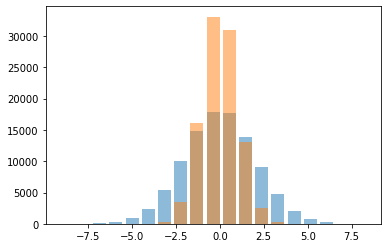

In [3]:
N_SIZE = 100000
μ1 = 0
μ2 = 0
std1 = 2
std2 = 1

P = np.random.normal(loc=μ1, scale=std1, size=N_SIZE)
Q = np.random.normal(loc=μ2, scale=std2, size=N_SIZE)

bins = np.linspace(np.min([*P, *Q]), np.max([*P, *Q]), 20)

fig, ax = plt.subplots(1)
ax.hist(P, alpha=0.5, bins=bins, rwidth = 0.8)
ax.hist(Q, alpha=0.5, bins=bins, rwidth = 0.8)
plt.show()

Illustration of the CDF and the interpolation

In [4]:
#regular CDF
sorted_P = np.sort(P)
count_P = np.array(range(1,N_SIZE+1))/float(N_SIZE)

#reduced CDF and interpolation
sorted_P_reduced, count_P_reduced = cumcount_reduced(P)
interp = interp1d(sorted_P_reduced, count_P_reduced)

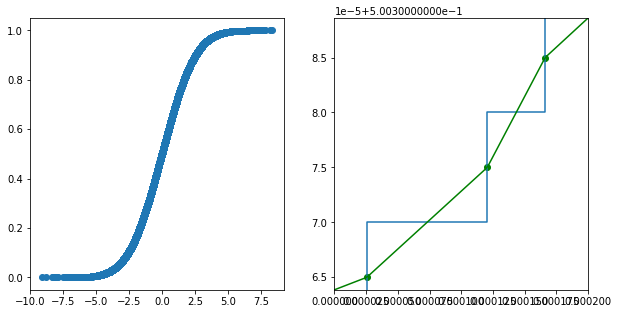

In [5]:
x_interp = np.linspace(0.0, .0002, 100)
y_interp = interp(x_interp)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(sorted_P_reduced, count_P_reduced, marker='o')

ax2.plot(sorted_P, count_P,drawstyle='steps-post')
ax2.scatter(sorted_P_reduced, count_P_reduced,color='g')
ax2.plot(x_interp, y_interp, color='g')
plt.xlim(0.0, .0002)
plt.ylim(interp(0.0), interp(.0002))
plt.show()

Comparison to the correct value

In [6]:
%%time
μ1 = 0
μ2 = 0
std1 = 1
std2 = 1
N_SIZE = 1000000


vec = []
for std1 in np.linspace(0.1,3,21):

    P = np.random.normal(loc=μ1, scale=std1, size=N_SIZE)
    Q = np.random.normal(loc=μ2, scale=std2, size=N_SIZE)

    dist_P = lambda x: scipy.stats.norm.pdf(x, μ1, std1)
    dist_Q = lambda x: scipy.stats.norm.pdf(x, μ2, std2)
    KLD = lambda x: dist_P(x)*np.log(dist_P(x)/dist_Q(x))
    res, abserr = integrate.quad(KLD, -20, 30)
    
    vec.append([std1, res, KLD_PerezCruz(P, Q)])
    
print(f'The correct value is: {res}')

print(f'The value obtained from the method with {N_SIZE} points is: {KLD_PerezCruz(P, Q)}')

The correct value is: 2.901387708917689
The value obtained from the method with 1000000 points is: 1.892014465215091
CPU times: user 33.8 s, sys: 681 ms, total: 34.4 s
Wall time: 34.4 s


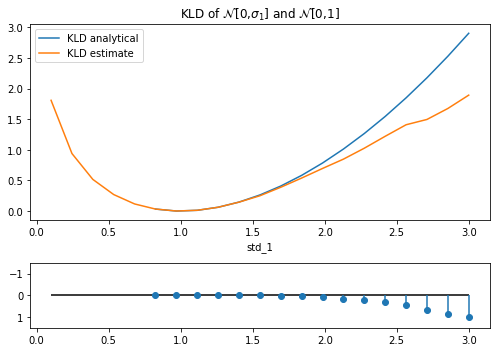

In [16]:
xval = np.array([x[0] for x in vec])
yval = np.array([x[1] for x in vec])
yval2 = np.array([x[2] for x in vec])

fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(7,5), gridspec_kw={'height_ratios': [3, 1]})

ax.plot(xval, yval, label='KLD analytical')
ax.plot(xval, yval2, label='KLD estimate')

ax.set_title(r'KLD of $\mathcal{N}$[0,$\sigma_1$] and $\mathcal{N}$[0,1]')
ax.set_xlabel('std_1')

residues = (yval - yval2)

ax_res.scatter(xval, residues)
ax_res.vlines(xval, 0,  residues)
ax_res.hlines(0, min(xval), max(xval), color='black', zorder=-1)
max_res = np.max(np.abs(residues[~np.isnan(residues)]))

ax_res.set_ylim(max_res + 0.5, -max_res -0.5, )

ax.legend()

plt.tight_layout()
plt.show()

We suppose that for empirical distributions with very different supports the result will deviate from expected due to lack of sampling some data

Convergence of the method

In [8]:
%%time

n_runs = 1000
n_simulations = 10
simulation_sizes = [500 + 1000 * i for i in range(n_simulations)]
μ1 = 0
μ2 = 1
std1 = 1
std2 = 1

dist_P = lambda x: scipy.stats.norm.pdf(x, μ1, std1)
dist_Q = lambda x: scipy.stats.norm.pdf(x, μ2, std2)
KLD = lambda x: dist_P(x)*np.log(dist_P(x)/dist_Q(x))
res, abserr = integrate.quad(KLD, -20, 30)

execution_times = []
results = []
result_std = []

for size in simulation_sizes:
    start = time.time()
    current_sim_results = []
    for sim in range(n_runs):
        P = np.random.normal(μ1, std1, size=size)
        Q = np.random.normal(μ2, std2, size=size)
        current_sim_results.append(KLD_PerezCruz(P, Q))

    results.append(np.mean(current_sim_results))
    result_std.append(np.std(current_sim_results)) 
    execution_times.append(time.time() - start)
    
results = np.array(results)
result_std = np.array(result_std)

CPU times: user 39 s, sys: 250 µs, total: 39 s
Wall time: 39 s


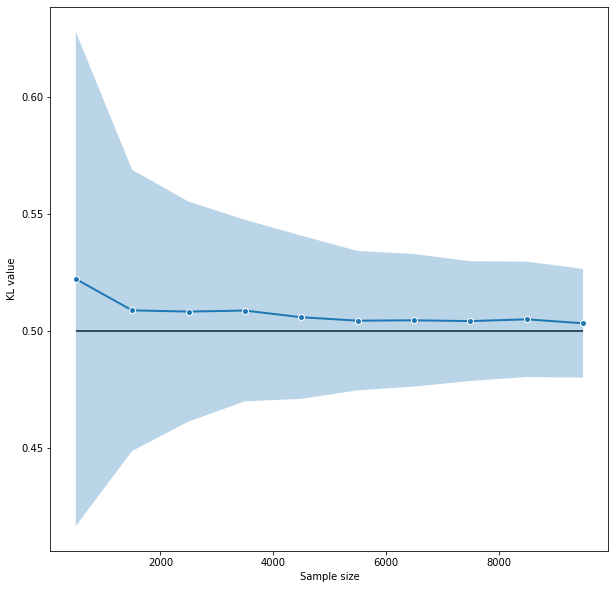

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))
positions = list(range(len(results)))
ax.plot(simulation_sizes, results, lw=2, marker='o', mec='white')
ax.fill_between(simulation_sizes, results + result_std, results - result_std, alpha=0.3)

#ax.set_title('KL converge for N(0, 1) and N(1, 1)', fontsize=24)
ax.set_ylabel('KL value')
ax.set_xlabel('Sample size')
ax.hlines(res, simulation_sizes[0], simulation_sizes[-1], color='black', alpha=1, zorder=-1)
plt.show()

Text(0, 0.5, 'KL calculation time (s)')

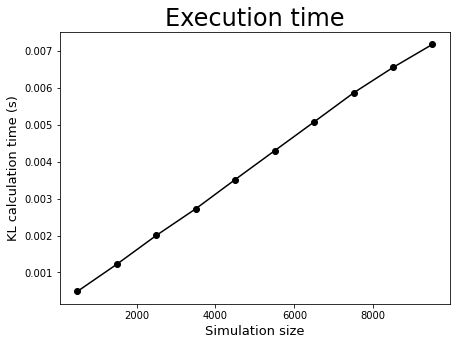

In [10]:
fig, ax = plt.subplots(1, figsize=(7, 5))

ax.plot(
    simulation_sizes,
    np.array(execution_times) / n_runs,
    color='black',
    marker='o',
)

ax.set_title('Execution time', fontsize=24)
ax.set_xlabel('Simulation size', fontsize=13)
ax.set_ylabel('KL calculation time (s)', fontsize=13)
